In [61]:
import csv
# Extract the original timestamp of 100,000 packets
list_all_p = []
with open('100000_packets_mirai.tsv', 'r', encoding="utf8") as tsv_in: 
    tsv_reader = csv.reader(tsv_in, delimiter='\t')
    for row in tsv_reader:
        list_all_p.append(row)
        
####################################################################################


list_all_t = list_all_p[:] 

# Expand the time interval
IEI = 22  
E = 3 / IEI  
packets_tsv = '100000_packets_mirai_time_{0}*{1}.tsv'.format(E,IEI) 

fx = open(packets_tsv,'w')
fx_writer = csv.writer(fx, delimiter='\t')
fx_writer.writerow(list_all_t[0]) 

list_all_mal = []
time_interval = []
with open('100000_labels_mirai.tsv', 'r') as l: 
    labels_reader = l.readlines()
    for i in range(0, len(labels_reader)):
        if labels_reader[i].find('0') != -1: 
            fx_writer.writerow(list_all_t[i+1])
        else:
            list_all_mal.append(list_all_t[i+1])
print(len(list_all_mal))

for i in range(1, len(list_all_mal)):
    tmp1 = float(list_all_mal[i][0]) # now
    tmp2 = float(list_all_mal[i-1][0]) # Last moment
    time_interval.append(tmp1 - tmp2)
for i in range(0, int(E*IEI)):
    fx_writer.writerow(list_all_mal[i])
for i in range(int(E*IEI), len(list_all_mal)):
    if i%(int(E*IEI)) == 0:
        list_all_mal[i][0] = time_interval[i-1] * (IEI+1) + float(list_all_mal[i-1][0])
    else:
        list_all_mal[i][0] = time_interval[i-1] + float(list_all_mal[i-1][0])
    fx_writer.writerow(list_all_mal[i])
fx.close() 

30001


counting lines in file...
There are 100001 Packets.
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
Running Kitsune:
1000
2000
3000
4000
5000
origional ids of the features
[[35]]
origional ids of the features
[[48, 20, 41, 27, 34]]
origional ids of the features
[[71, 78, 85, 92, 99]]
origional ids of the features
[[21, 28]]
origional ids of the features
[[42, 49]]
origional ids of the features
[[91, 98, 84, 70, 77]]
origional ids of the features
[[61, 58, 52, 55, 64, 63, 60, 57, 51, 54]]
origional ids of the features
[[81, 67, 74, 82, 68, 75, 88, 95, 89, 96]]
origional ids of the features
[[39, 46, 14, 45, 11, 38]]
origional ids of the features
[[32, 18, 25, 8, 31, 5, 24, 2, 17]]
origional ids of the features
[[13, 44, 10, 37]]
origional ids of the features
[[87, 94, 80, 66, 73]]
origional ids of the features
[[7, 30, 4, 23, 1, 16]]
origional ids of the features
[[90, 97, 83, 69, 76, 40, 47, 33, 19, 26]]
origional ids of the features
[[12, 43, 9, 36]]
origional ids of the featur

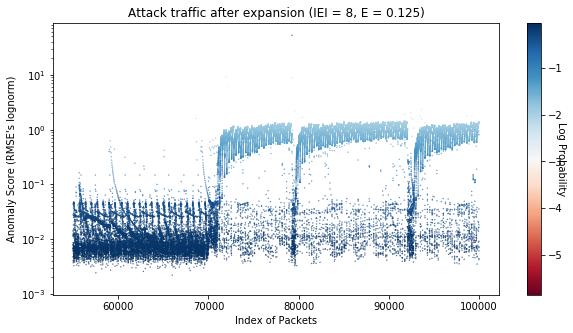

In [33]:
########################################################################
# Put 100,000 data packets in kitsune for detection-purely expand the time interval without adding forged packets
########################################################################

import time
import os
import subprocess
import csv
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.mixture import GaussianMixture 
from Kitsune import Kitsune

#IEI = 2 

# File location
path = packets_tsv
packet_limit = np.Inf #the number of packets to process

# KitNET params:
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)  
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself)  

# Build Kitsune
K = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace) 

print("Running Kitsune:")
RMSEs = []
i = 0
start = time.time()
# Here we process (train/execute) each individual packet.
# In this way, each observation is discarded after performing process() method.
while True:
    i+=1
    if i % 1000 == 0:
        print(i)
    rmse, _ = K.proc_next_packet()
    if rmse == -1:
        break
    RMSEs.append(rmse)
stop = time.time()
print("Complete. Time elapsed: "+ str(stop - start))

#threshold = max(RMSEs[0: 69999])
threshold = 1.595525749859174 

labels = []
for line in open("100000_labels_mirai.tsv"): 
    if line.find('0') != -1: 
        labels.append(0)
    elif line.find('1') != -1: 
        labels.append(1)

mal_tot = 6001 
# dis_tot = gen_samples_num
# dis_mal_tot = gen_samples_num * (1 + 1)
all_mal_tot = 30001 
mal_num = 0
# dis_num = 0
# dis_mal_num = 0
all_mal_num = 0
num = 0
for i in range(FMgrace + ADgrace + 1, 100000):
    if labels[i] == 1:
        num += 1
        if RMSEs[i] > threshold: 
            all_mal_num += 1
            if num > all_mal_tot - mal_tot:
                mal_num += 1

all_mal_TPR = all_mal_num / all_mal_tot
mal_TPR = mal_num / mal_tot
# dis_TPR = dis_num / dis_tot
# dis_mal_TPR = dis_mal_num / dis_mal_tot
all_MRR = (24559 - all_mal_num) / 24559 
MRR = (5252 - mal_num) / 5252 
print('Threshold: {0}'.format(threshold))
print('all_mal_TPR: {0} / {1} = {2:0.4f}'.format(all_mal_num,all_mal_tot,all_mal_TPR))
print('mal_TPR: {0} / {1} = {2:0.4f}'.format(mal_num,mal_tot,mal_TPR))
# print('dis_TPR: {0} / {1} = {2:0.4f}'.format(dis_num,dis_tot,dis_TPR))
# print('dis_mal_TPR: {0} / {1} = {2:0.4f}'.format(dis_mal_num,dis_mal_tot,dis_mal_TPR))
print('all_MRR: 24559 - {0} / 24559 = {1:0.4f}'.format(all_mal_num,all_MRR)) 
print('MRR: 5252 - {0} / 5252 = {1:0.4f}'.format(mal_num,MRR)) 
                
# Here we demonstrate how one can fit the RMSE scores to a log-normal distribution (useful for finding/setting a cutoff threshold \phi)
from scipy.stats import norm
benignSample = np.log(RMSEs[FMgrace+ADgrace+1:])
logProbs = norm.logsf(np.log(RMSEs), np.mean(benignSample), np.std(benignSample))

from matplotlib import pyplot as plt
# plot the RMSE anomaly scores
print("Plotting results")
plt.figure(figsize=(10,5))
fig = plt.scatter(range(FMgrace+ADgrace+1,len(RMSEs)),RMSEs[FMgrace+ADgrace+1:],s=0.1,c=logProbs[FMgrace+ADgrace+1:],cmap='RdBu')
plt.yscale("log")
plt.title("Attack traffic after expansion (IEI = {0}, E = {1})".format(IEI,E))
plt.ylabel("Anomaly Score (RMSE's lognorm)")
plt.xlabel("Index of Packets")
figbar=plt.colorbar()
figbar.ax.set_ylabel('Log Probability\n\n', rotation=270)
plt.savefig("Mirai Attack traffic after expansion (IEI = {0}, E = {1}).pdf".format(IEI,E))
plt.savefig("Mirai Attack traffic after expansion (IEI = {0}, E = {1}).eps".format(IEI,E))
plt.savefig("Mirai Attack traffic after expansion (IEI = {0}, E = {1}).png".format(IEI,E))
plt.show()


In [85]:
IEI = 8 
E = 1 / IEI 
packets_tsv = '100000_packets_mirai_time_{0}*{1}.tsv'.format(E,IEI) 

In [86]:
import csv
# Extract the timestamp of the 100000 expanded packets
list_all_t = []
with open(packets_tsv, 'r', encoding="utf8") as tsv_in:
    tsv_reader = csv.reader(tsv_in, delimiter='\t')
    for row in tsv_reader:
        list_all_t.append(row)
        
######################################################################################       


import random

# First modify the timestamp of the 6001 adversarial sample
list_m = []
with open('Mirai_gen_test.tsv', 'r', encoding="utf8") as tsv_in: 
    tsv_reader = csv.reader(tsv_in, delimiter='\t')
    for row in tsv_reader:
        list_m.append(row)

# #Insert forged packets evenly
# for i in range(0, len(list_m)):
#     end = float(list_all_t[-1 * int(E*IEI) * (6001 - i)][0]) 
#     start = float(list_all_t[-1 * int(E*IEI) * (6001 - i) - 1][0]) 
#     list_m[i][0] = random.uniform(start,end)

end = float(list_all_t[-1][0])
start = float(list_all_t[-1 * int(E*IEI) * (6001) - 1][0]) 
for i in range(0, len(list_m)): 
    list_m[i][0] = random.uniform(start,end)


def takeFirst(elem):
    return elem[0]
list_m.sort(key=takeFirst)
    
f = open('Mirai_gen_test_modify_time_epoch.tsv','w') 
writer = csv.writer(f, delimiter='\t')
for m_row in list_m:
    writer.writerow(m_row)
f.close()

######################################################################################  
# Then insert 6001 adversarial samples with modified timestamps into the original 100,000 data packets
# At the same time, insert the labels of 6001 adversarial samples into the original 100,000 packet label files
list_x = []
list_y = []
list_z = []
list_k = []

with open('Mirai_gen_test_modify_time_epoch.tsv', 'r', encoding="utf8") as x,\
open(packets_tsv, 'r', encoding="utf8") as y,\
open('100000_labels_mirai.tsv', 'r', encoding="utf8") as z: 
    x_reader = csv.reader(x, delimiter='\t')
    y_reader = csv.reader(y, delimiter='\t')
    z_reader = csv.reader(z, delimiter='\t')
    for x_row in x_reader:
        list_x.append(x_row)
        list_k.append('2') 
    for y_row in y_reader:
        list_y.append(y_row)
    for z_row in z_reader:
        list_z.append(z_row) 
gen_samples_num = len(list_x)
print(len(list_x))
print(len(list_y))
print(len(list_z))
list_p = []
list_l = []
list_p.append(list_y[0]) 
del list_y[0]
while len(list_x) > 0 and len(list_y) > 0:
    if list_x[0][0] < list_y[0][0]:
        list_p.append(list_x[0])
        del list_x[0]
        list_l.append(list_k[0])
        del list_k[0]
    else:
        list_p.append(list_y[0])
        del list_y[0]
        list_l.append(list_z[0])
        del list_z[0]
list_p.extend(list_x)
list_p.extend(list_y)
list_l.extend(list_k)
list_l.extend(list_z)
print("merge success")
print(len(list_p))
print(len(list_l))
    
f = open('100000*1.2_packets_mirai.tsv','w')
writer = csv.writer(f, delimiter='\t')
fla = open('100000*1.2_labels_mirai.tsv','w')
writerla = csv.writer(fla, delimiter='\t')
for p_row in list_p:
    writer.writerow(p_row)
for l_row in list_l:
    writerla.writerow(l_row)
f.close()
fla.close()

6001
100001
100000
merge success
106002
106001


counting lines in file...
There are 106002 Packets.
Feature-Mapper: train-mode, Anomaly-Detector: off-mode
Running Kitsune:
1000
2000
3000
4000
5000
origional ids of the features
[[35]]
origional ids of the features
[[48, 20, 41, 27, 34]]
origional ids of the features
[[71, 78, 85, 92, 99]]
origional ids of the features
[[21, 28]]
origional ids of the features
[[42, 49]]
origional ids of the features
[[91, 98, 84, 70, 77]]
origional ids of the features
[[61, 58, 52, 55, 64, 63, 60, 57, 51, 54]]
origional ids of the features
[[81, 67, 74, 82, 68, 75, 88, 95, 89, 96]]
origional ids of the features
[[39, 46, 14, 45, 11, 38]]
origional ids of the features
[[32, 18, 25, 8, 31, 5, 24, 2, 17]]
origional ids of the features
[[13, 44, 10, 37]]
origional ids of the features
[[87, 94, 80, 66, 73]]
origional ids of the features
[[7, 30, 4, 23, 1, 16]]
origional ids of the features
[[90, 97, 83, 69, 76, 40, 47, 33, 19, 26]]
origional ids of the features
[[12, 43, 9, 36]]
origional ids of the featur

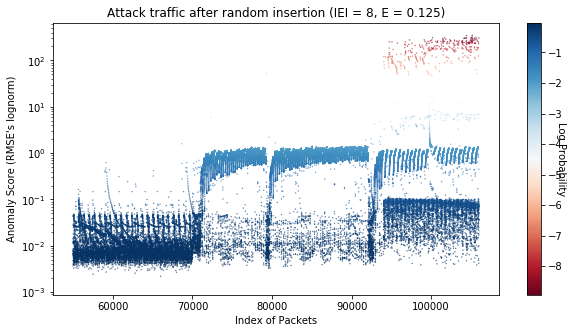

In [87]:
########################################################################
# Put 100000*1.2 packets into kitsune for inspection
########################################################################

import time
import os
import subprocess
import csv
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.mixture import GaussianMixture 
from Kitsune import Kitsune

# File location
path = "100000*1.2_packets_mirai.tsv" 
packet_limit = np.Inf #the number of packets to process

# KitNET params:
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)  
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself)  

# Build Kitsune
K = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace)

print("Running Kitsune:")
RMSEs = []
i = 0
start = time.time()
# Here we process (train/execute) each individual packet.
# In this way, each observation is discarded after performing process() method.
while True:
    i+=1
    if i % 1000 == 0:
        print(i)
    rmse, _ = K.proc_next_packet()
    if rmse == -1:
        break
    RMSEs.append(rmse)
stop = time.time()
print("Complete. Time elapsed: "+ str(stop - start))

#threshold = max(RMSEs[0: 69999])
threshold = 1.595525749859174 

labels = []
for line in open("100000*1.2_labels_mirai.tsv"):  
    if line.find('0') != -1: 
        labels.append(0)
    elif line.find('1') != -1: 
        labels.append(1)
    elif line.find('2') != -1:
        labels.append(2)

mal_tot = min(gen_samples_num * int(E*IEI), 30001) 
dis_tot = gen_samples_num
dis_mal_tot = gen_samples_num * (int(E*IEI) + 1)
or_mal_tot = max(30001 - mal_tot, 0) 
mal_num = 0
dis_num = 0
dis_mal_num = 0
#or_mal_num = 0
num = 0
for i in range(FMgrace + ADgrace + 1, 100000 + gen_samples_num): 
    if labels[i] == 1 or labels[i] == 2:
        num += 1
        if RMSEs[i] > threshold: 
            if num >= or_mal_tot:
                dis_mal_num += 1
                if labels[i] == 1:
                    mal_num += 1
                else:
                    dis_num += 1

#or_mal_TPR = or_mal_num / or_mal_tot
mal_TPR = mal_num / mal_tot
dis_TPR = dis_num / dis_tot
dis_mal_TPR = dis_mal_num / dis_mal_tot
if int(E*IEI) == 1:
    origin_mal_num = 5252 
elif int(E*IEI) == 2:
    origin_mal_num = 10016 
elif int(E*IEI) == 3:
    origin_mal_num = 15324  
elif int(E*IEI) == 4:
    origin_mal_num = 20328  
elif int(E*IEI) == 5:
    origin_mal_num = 24559  
MRR = (origin_mal_num - mal_num) / origin_mal_num 
print('Threshold: {0}'.format(threshold))
#print('or_mal_TPR: {0} / {1} = {2:0.4f}'.format(or_mal_num,or_mal_tot,or_mal_TPR))
print('mal_TPR: {0} / {1} = {2:0.4f}'.format(mal_num,mal_tot,mal_TPR))
print('dis_TPR: {0} / {1} = {2:0.4f}'.format(dis_num,dis_tot,dis_TPR))
print('dis_mal_TPR: {0} / {1} = {2:0.4f}'.format(dis_mal_num,dis_mal_tot,dis_mal_TPR))
print('MRR: {0} - {1} / {2} = {3:0.4f}'.format(origin_mal_num,mal_num,origin_mal_num,MRR)) 
                
# Here we demonstrate how one can fit the RMSE scores to a log-normal distribution (useful for finding/setting a cutoff threshold \phi)
from scipy.stats import norm
benignSample = np.log(RMSEs[FMgrace+ADgrace+1:])
logProbs = norm.logsf(np.log(RMSEs), np.mean(benignSample), np.std(benignSample)) 

from matplotlib import pyplot as plt
# plot the RMSE anomaly scores
print("Plotting results")
plt.figure(figsize=(10,5))
fig = plt.scatter(range(FMgrace+ADgrace+1,len(RMSEs)),RMSEs[FMgrace+ADgrace+1:],s=0.1,c=logProbs[FMgrace+ADgrace+1:],cmap='RdBu')
plt.yscale("log") 
# plt.title("Attack traffic after insertion (IEI = {0}, E = {1})".format(IEI,E))
# plt.ylabel("Anomaly Score (RMSE's lognorm)")
# plt.xlabel("Index of Packets")
# figbar=plt.colorbar()
# figbar.ax.set_ylabel('Log Probability\n\n', rotation=270)
# plt.savefig("Mirai Attack traffic after insertion (IEI = {0}, E = {1}).pdf".format(IEI,E))
# plt.savefig("Mirai Attack traffic after insertion (IEI = {0}, E = {1}).eps".format(IEI,E))
# plt.savefig("Mirai Attack traffic after insertion (IEI = {0}, E = {1}).png".format(IEI,E))
# plt.show()

plt.title("Attack traffic after random insertion (IEI = {0}, E = {1})".format(IEI,E))
plt.ylabel("Anomaly Score (RMSE's lognorm)")
plt.xlabel("Index of Packets")
figbar=plt.colorbar()
figbar.ax.set_ylabel('Log Probability\n\n', rotation=270)
plt.savefig("Mirai Attack traffic after random insertion (IEI = {0}, E = {1}).pdf".format(IEI,E))
plt.savefig("Mirai Attack traffic after random insertion (IEI = {0}, E = {1}).eps".format(IEI,E))
plt.savefig("Mirai Attack traffic after random insertion (IEI = {0}, E = {1}).png".format(IEI,E))
plt.show()